In [9]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from skimage import io, measure, exposure
#import image_preprocessing as pp
import pickle
import scipy.io
import h5py
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [2]:
filename = '3000_25_50_50.h5'  #here is the absolute path to the h5 file.
data = h5py.File(filename, 'r')  #read the h5 file into data.
list(data.keys())  # with this command you can see all the keys you have stored

['img_data', 'labels', 'slice_location']

In [37]:
X = np.asarray(list(data['img_data']))
y = list(data['labels'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
print(X_train.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_test))

(4800, 25, 50, 50, 1)
(1200, 25, 50, 50, 1)
4800
1200


In [12]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D, ZeroPadding3D
from keras.optimizers import Adamax, SGD
from keras.utils.np_utils import to_categorical

def get_model(summary=False):
    """ Return the Keras model of the network
    """
    #input_shape = X.shape
    model = Sequential()
    # 1st layer group
    model.add(Convolution3D(64,(3, 3, 3), input_shape = (25,50,50,1), activation='relu', 
                            padding='same', name='conv1'))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), 
                           padding='valid', name='pool1'))
    # 2nd layer group
    model.add(Convolution3D(128,(3, 3, 3), activation='relu', 
                            padding='same', name='conv2',
                            strides=(1, 1, 1)))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), 
                           padding='valid', name='pool2'))
    # 3rd layer group
    model.add(Convolution3D(256,(3, 3, 3), activation='relu', 
                            padding='same', name='conv3a',
                            strides=(1, 1, 1)))
    model.add(Convolution3D(256,(3, 3, 3), activation='relu', 
                            padding='same', name='conv3b',
                            strides=(1, 1, 1)))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), 
                           padding='valid', name='pool3'))
    # 4th layer group
    model.add(Convolution3D(512,(3, 3, 3), activation='relu', 
                            padding='same', name='conv4a',
                            strides=(1, 1, 1)))
    model.add(Convolution3D(512,(3, 3, 3), activation='relu', 
                            padding='same', name='conv4b',
                            strides=(1, 1, 1)))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), 
                           padding='valid', name='pool4'))
    # 5th layer group
    model.add(Convolution3D(512,(3, 3, 3), activation='relu', 
                            padding='same', name='conv5a',
                            strides=(1, 1, 1)))
    model.add(Convolution3D(512,(3, 3, 3), activation='relu', 
                            padding='same', name='conv5b',
                            strides=(1, 1, 1)))
    model.add(ZeroPadding3D(padding=(0, 1, 1)))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), 
                           padding='valid', name='pool5'))
    model.add(Flatten())
    # FC layers group
    model.add(Dense(4096, activation='relu', name='fc6'))
    model.add(Dropout(.3))
    model.add(Dense(4096, activation='relu', name='fc7'))
    model.add(Dropout(.3))
    model.add(Dense(487, activation='softmax', name='fc8'))
    model.add(Dense(2, activation='softmax', name='out'))
    if summary:
        print(model.summary())
    return model

def CNN_compile(loss="binary_crossentropy",metrics=['accuracy']):
    """
    This function compiles the given model with choosen loss function,
    optimizer and evaluation metrics.
    
    Args:
        loss: loss function for the model. Recommend "binary_crossentropy".
        Visit 'https://keras.io/losses/' for more information.
        optimizer: An optimizer is one of the two arguments required for compiling a Keras model.
        Visit 'https://keras.io/optimizers/' for more information.
        metric: A metric is a function that is used to judge the performance of your model. 
        Visit 'https://keras.io/metrics/' for more information. 
    Returns:
        compiled CNN model.
    """
    model = get_model(summary=False)
    opt = Adamax(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    model.compile(loss=loss,
                  optimizer=opt,
                  metrics=metrics)
    return model

def CNN_fit(array,label, batch_size, epochs, validation_split):
    
    le = LabelEncoder()
    le.fit(label)
    y= le.transform(label)
    y = to_categorical(y)
    
    model = CNN_compile(loss='categorical_crossentropy',
            metrics=['accuracy'])
    model.fit(array, y , batch_size= batch_size, epochs= epochs, validation_split= validation_split)
    return

In [9]:
history = CNN_fit(X_train,y_train, validation_split=0.25, epochs=50, batch_size=40)

Instructions for updating:
Use tf.cast instead.
Train on 3600 samples, validate on 1200 samples
Epoch 1/50
3600/3600 [==============================] - 164s 45ms/step - loss: 0.6941 - sparse_categorical_accuracy: 0.5044 - val_loss: 0.6931 - val_sparse_categorical_accuracy: 0.5067
Epoch 2/50
3600/3600 [==============================] - 154s 43ms/step - loss: 0.6934 - sparse_categorical_accuracy: 0.4967 - val_loss: 0.6931 - val_sparse_categorical_accuracy: 0.5067
Epoch 3/50
3600/3600 [==============================] - 155s 43ms/step - loss: 0.6933 - sparse_categorical_accuracy: 0.4972 - val_loss: 0.6931 - val_sparse_categorical_accuracy: 0.5067
Epoch 4/50
3600/3600 [==============================] - 155s 43ms/step - loss: 0.6932 - sparse_categorical_accuracy: 0.5033 - val_loss: 0.6931 - val_sparse_categorical_accuracy: 0.5067
Epoch 5/50
3600/3600 [==============================] - 155s 43ms/step - loss: 0.6936 - sparse_categorical_accuracy: 0.4900 - val_loss: 0.6931 - val_sparse_categori

KeyboardInterrupt: 

In [30]:
model = get_model(summary=False)
opt = SGD(lr=0.001)
model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    le = LabelEncoder()
    le.fit(label)
    y= le.transform(label)
    y = to_categorical(y)
history = model.fit(X_train,y_train, validation_split=0.25, epochs=10, batch_size=40)

Train on 3600 samples, validate on 1200 samples
Epoch 1/10
3600/3600 [==============================] - 161s 45ms/step - loss: 0.6932 - acc: 0.5006 - val_loss: 0.6931 - val_acc: 0.5050
Epoch 2/10
3600/3600 [==============================] - 160s 44ms/step - loss: 0.6932 - acc: 0.5006 - val_loss: 0.6931 - val_acc: 0.5050
Epoch 3/10
3600/3600 [==============================] - 160s 44ms/step - loss: 0.6932 - acc: 0.5006 - val_loss: 0.6931 - val_acc: 0.5050
Epoch 4/10
3600/3600 [==============================] - 160s 44ms/step - loss: 0.6932 - acc: 0.5006 - val_loss: 0.6931 - val_acc: 0.5050
Epoch 5/10
3600/3600 [==============================] - 160s 44ms/step - loss: 0.6932 - acc: 0.5006 - val_loss: 0.6931 - val_acc: 0.5050
Epoch 6/10
3600/3600 [==============================] - 160s 44ms/step - loss: 0.6932 - acc: 0.5006 - val_loss: 0.6931 - val_acc: 0.5050
Epoch 7/10
3600/3600 [==============================] - 160s 44ms/step - loss: 0.6932 - acc: 0.5006 - val_loss: 0.6931 - val_acc: 

In [33]:
model = get_model(summary=False)
opt = SGD(lr=0.00001)
model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
le = LabelEncoder()
le.fit(y_train)
y= le.transform(y_train)
y = to_categorical(y)
history = model.fit(X_train,y, validation_split=0.2, epochs=10, batch_size=30)

Train on 3840 samples, validate on 960 samples
Epoch 1/10
3840/3840 [==============================] - 183s 48ms/step - loss: 0.6932 - acc: 0.4969 - val_loss: 0.6931 - val_acc: 0.5208
Epoch 2/10
3840/3840 [==============================] - 178s 46ms/step - loss: 0.6932 - acc: 0.4969 - val_loss: 0.6931 - val_acc: 0.5208
Epoch 3/10
3840/3840 [==============================] - 178s 46ms/step - loss: 0.6932 - acc: 0.4969 - val_loss: 0.6931 - val_acc: 0.5208
Epoch 4/10
3840/3840 [==============================] - 178s 46ms/step - loss: 0.6932 - acc: 0.4969 - val_loss: 0.6931 - val_acc: 0.5208
Epoch 5/10
3840/3840 [==============================] - 178s 46ms/step - loss: 0.6932 - acc: 0.4969 - val_loss: 0.6931 - val_acc: 0.5208
Epoch 6/10
3840/3840 [==============================] - 178s 46ms/step - loss: 0.6932 - acc: 0.4969 - val_loss: 0.6931 - val_acc: 0.5208
Epoch 7/10
3840/3840 [==============================] - 178s 46ms/step - loss: 0.6932 - acc: 0.4969 - val_loss: 0.6931 - val_acc: 0

In [35]:
model = get_model(summary=False)
opt = Adamax(lr=0.000001) #10e-6
model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
le = LabelEncoder()
le.fit(y_train)
y= le.transform(y_train)
y = to_categorical(y)
history = model.fit(X_train,y, validation_split=0.2, epochs=5, batch_size=30)

Train on 3840 samples, validate on 960 samples
Epoch 1/5
3840/3840 [==============================] - 183s 48ms/step - loss: 0.6931 - acc: 0.5031 - val_loss: 0.6932 - val_acc: 0.4792
Epoch 2/5
3840/3840 [==============================] - 181s 47ms/step - loss: 0.6931 - acc: 0.5031 - val_loss: 0.6932 - val_acc: 0.4792
Epoch 3/5
3840/3840 [==============================] - 181s 47ms/step - loss: 0.6931 - acc: 0.5031 - val_loss: 0.6932 - val_acc: 0.4792
Epoch 4/5
3840/3840 [==============================] - 181s 47ms/step - loss: 0.6931 - acc: 0.5031 - val_loss: 0.6932 - val_acc: 0.4792
Epoch 5/5
3840/3840 [==============================] - 181s 47ms/step - loss: 0.6931 - acc: 0.5031 - val_loss: 0.6932 - val_acc: 0.4792


In [38]:
slice_location = list(data['slice_location'])
df3 = pd.DataFrame(slice_location, columns = ['z','x','y'])
df3['label'] = y
df3.head()

,z,x,y,label
0,11,123,60,b'V'
1,21,131,91,b'V'
2,36,139,128,b'V'
3,9,12,89,b'A'
4,86,89,96,b'A'


Text(0.5, 0, 'Z Label')

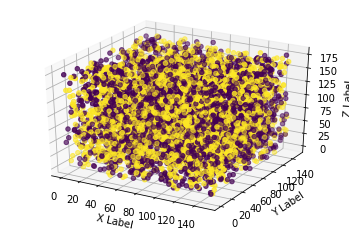

In [39]:
from mpl_toolkits import mplot3d
%matplotlib inline
fig = plt.figure()
ax = plt.axes(projection='3d')
le = LabelEncoder()
le.fit(df3['label'])
label = le.transform(df3['label']) 
ax.scatter3D(df3['x'], df3['y'], df3['z'], c = label);
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

In [3]:
filename = '../../me/3000_25_50_50.h5'  #here is the absolute path to the h5 file.
data2 = h5py.File(filename, 'r')  #read the h5 file into data.
list(data2.keys())  # with this command you can see all the keys you have stored

['img_data', 'labels', 'slice_location']

In [6]:
slice_location2 = list(data2['slice_location'])
y2 = list(data2['labels'])
X2 = np.asarray(list(data2['img_data']))
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=10)
print(X2_train.shape)
print(X2_test.shape)
print(len(y2_train))
print(len(y2_test))

(4800, 25, 50, 50, 1)
(1200, 25, 50, 50, 1)
4800
1200


Text(0.5, 0, 'Z Label')

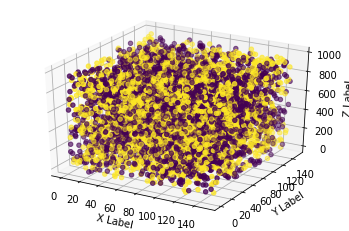

In [8]:
from mpl_toolkits import mplot3d
%matplotlib inline
df4 = pd.DataFrame(slice_location2, columns = ['z','x','y'])
df4['label'] = y2
fig = plt.figure()
ax = plt.axes(projection='3d')
le = LabelEncoder()
le.fit(df4['label'])
label = le.transform(df4['label']) 
ax.scatter3D(df4['x'], df4['y'], df4['z'], c = label);
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

In [13]:
model = get_model(summary=False)
opt = SGD(lr=0.001)
model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
le = LabelEncoder()
le.fit(y2_train)
y2= le.transform(y2_train)
y2 = to_categorical(y2)
history = model.fit(X2_train,y2, validation_split=0.25, epochs=10, batch_size=40)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 3600 samples, validate on 1200 samples
Epoch 1/10
  40/3600 [..............................] - ETA: 1:29:37 - loss: 0.6931 - acc: 0.5500

KeyboardInterrupt: 

In [16]:
from keras.utils import to_categorical

In [27]:

le = LabelEncoder()
le.fit(y_train)
y= le.transform(y_train)
y_1 = to_categorical(y)
y_1[:10]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)